Load 3 graphs:
- without column information -> G_org
- with column information by node degree >2 -> G_2
- with column information by node degree >1 -> G_1

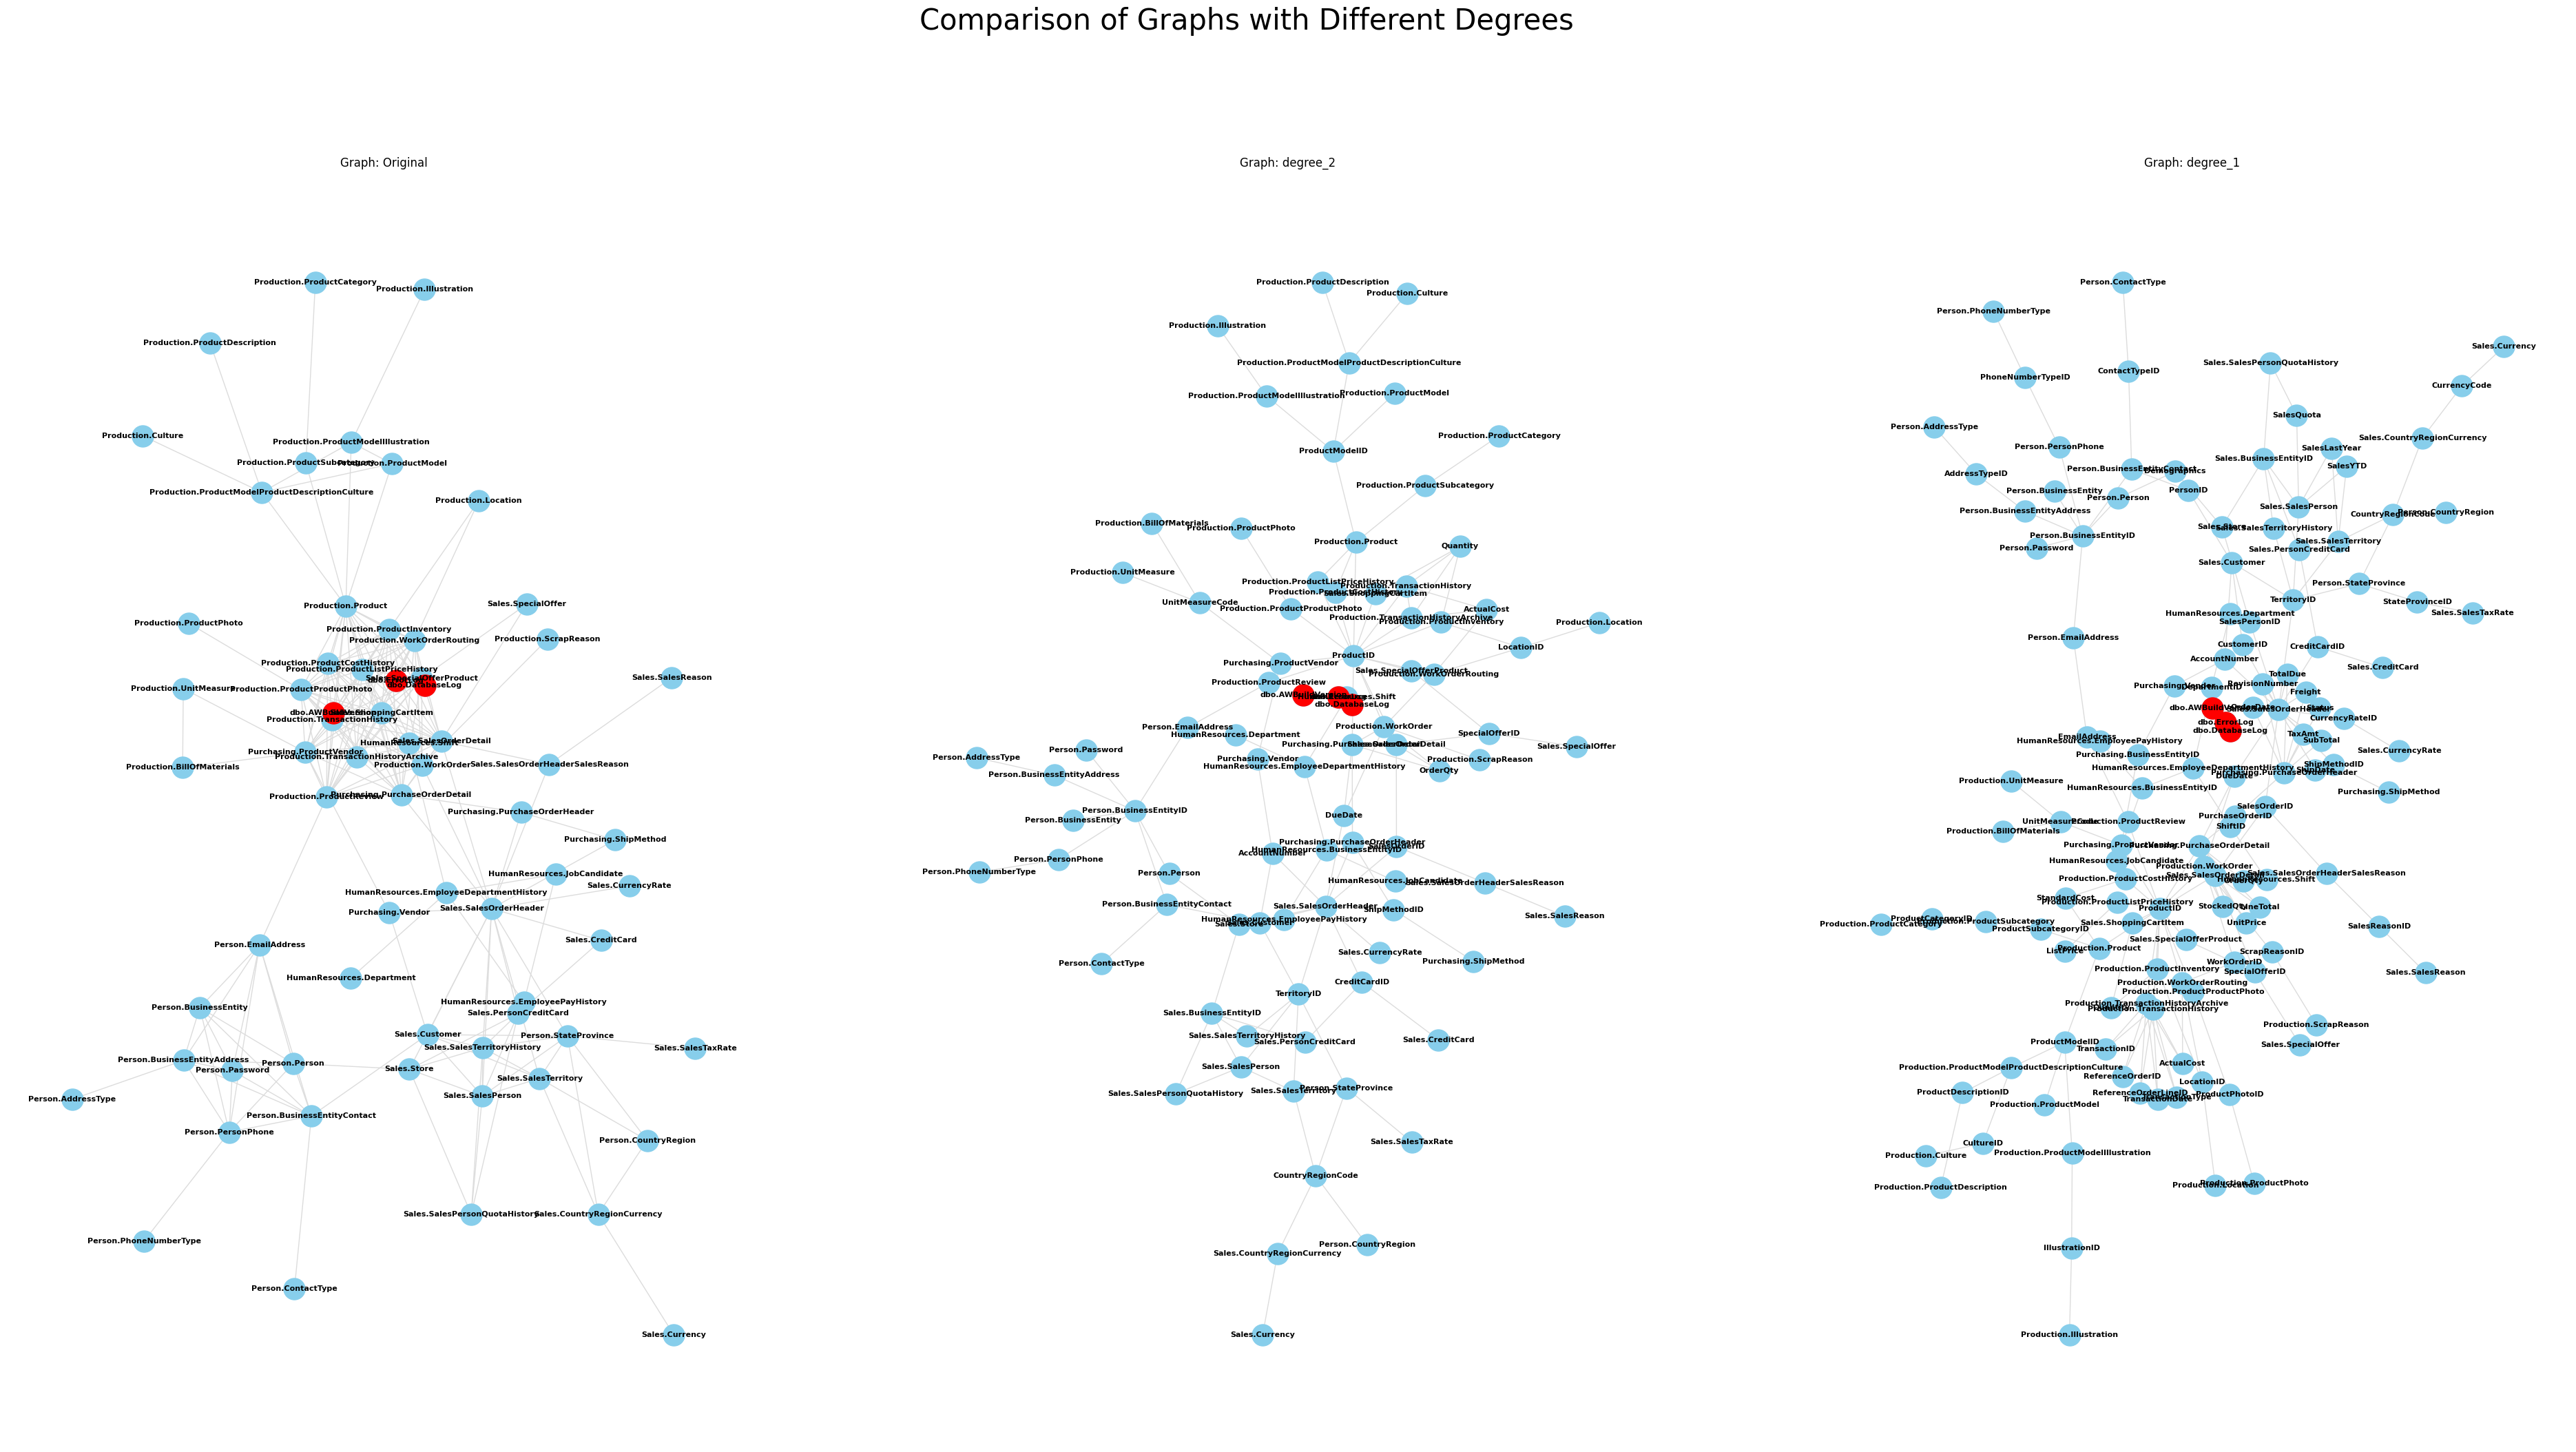

In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt

# Load the graphs
with open(r'C:\Python\Python\AAA_UNI\MBD\Project\adw_graph_degree_none.pickle', 'rb') as f:
    G_org = pickle.load(f)
with open(r'C:\Python\Python\AAA_UNI\MBD\Project\adw_graph_degree_2.pickle', 'rb') as f:
    G_2 = pickle.load(f)
with open(r'C:\Python\Python\AAA_UNI\MBD\Project\adw_graph_degree_1.pickle', 'rb') as f:
    G_1 = pickle.load(f)

# Define the layout positions
pos_org = nx.kamada_kawai_layout(G_org)
pos_2 = nx.kamada_kawai_layout(G_2)
pos_1 = nx.kamada_kawai_layout(G_1)

# Identify isolated nodes
isolated_nodes_org = list(nx.isolates(G_org))
isolated_nodes_2 = list(nx.isolates(G_2))
isolated_nodes_1 = list(nx.isolates(G_1))

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(48, 24))

# Plot each graph in a separate subplot
axs[0].set_title("Graph: Original")
nx.draw(G_org, pos_org, edge_color="gainsboro", with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', ax=axs[0])
nx.draw_networkx_nodes(G_org, pos_org, nodelist=isolated_nodes_org, node_color='red', node_size=500, ax=axs[0])

axs[1].set_title("Graph: degree_2")
nx.draw(G_2, pos_2, edge_color="gainsboro", with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', ax=axs[1])
nx.draw_networkx_nodes(G_2, pos_2, nodelist=isolated_nodes_2, node_color='red', node_size=500, ax=axs[1])

axs[2].set_title("Graph: degree_1")
nx.draw(G_1, pos_1, edge_color="gainsboro", with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', ax=axs[2])
nx.draw_networkx_nodes(G_1, pos_1, nodelist=isolated_nodes_1, node_color='red', node_size=500, ax=axs[2])

plt.suptitle("Comparison of Graphs with Different Degrees", fontsize=30)
plt.show()


Compute density

In [2]:
density_org = nx.density(G_org)
density_2 = nx.density(G_2)
density_1 = nx.density(G_1)

print(f"Density of Original Graph: {density_org:.4f}")
print(f"Density of degree_2 Graph: {density_2:.4f}")
print(f"Density of degree_1 Graph: {density_1:.4f}")

Density of Original Graph: 0.0932
Density of degree_2 Graph: 0.0308
Density of degree_1 Graph: 0.0200


Compute clustering coefficient

In [3]:
clustering_org = nx.average_clustering(G_org)
clustering_2 = nx.average_clustering(G_2)
clustering_1 = nx.average_clustering(G_1)

print(f"Average Clustering Coefficient of Original Graph: {clustering_org:.4f}")
print(f"Average Clustering Coefficient of degree_2 Graph: {clustering_2:.4f}")
print(f"Average Clustering Coefficient of degree_1 Graph: {clustering_1:.4f}")


Average Clustering Coefficient of Original Graph: 0.5441
Average Clustering Coefficient of degree_2 Graph: 0.1062
Average Clustering Coefficient of degree_1 Graph: 0.0000


CHOOSE THE GRAPH

In [4]:
# Choose graph
G = G_2

## Clique-based clustering application

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

def get_maximal_cliques(G):
    cliques = list(nx.find_cliques(G))
    return cliques

def clique_to_vector(clique, node_index_map):
    vector = [0] * len(node_index_map)
    for node in clique:
        vector[node_index_map[node]] = 1
    return vector

def calculate_similarity_matrix(G, cliques):
    nodes = list(G.nodes())
    node_index_map = {node: idx for idx, node in enumerate(nodes)}
    clique_vectors = [clique_to_vector(clique, node_index_map) for clique in cliques]
    similarity_matrix = cosine_similarity(clique_vectors)
    return similarity_matrix, node_index_map

def assign_cluster_labels(G, cliques, similarity_threshold=0.33): ### similarity threshold ###
    similarity_matrix, node_index_map = calculate_similarity_matrix(G, cliques)
    cluster_mapping = {}
    cluster_id = 0
    
    for i, clique in enumerate(cliques):
        assigned = False
        for j in range(i):
            if similarity_matrix[i][j] > similarity_threshold:
                cluster_id = cluster_mapping[cliques[j][0]]
                assigned = True
                break
        if not assigned:
            cluster_id += 1
        
        for node in clique:
            cluster_mapping[node] = cluster_id
    
    return cluster_mapping

cliques_org = get_maximal_cliques(G)
cluster_mapping_org = assign_cluster_labels(G, cliques_org)

print(f'Number of clusters: {len(set(cluster_mapping_org.values()))}')

Number of clusters: 3


In [6]:
import pandas as pd
def create_cluster_dataframe(cluster_mapping):
    data = [{'node_label': node, 'cluster_label': cluster} for node, cluster in cluster_mapping.items()]
    df = pd.DataFrame(data)
    return df
def update_index(index):
    return index-1
def get_node_colors(G, cluster_labels):
    num_clusters = len(set(cluster_labels))  # Number of clusters
    cmap = plt.cm.get_cmap('viridis', num_clusters)  # Colormap 
    node_colors = [cmap(label) for label in cluster_labels]
    return node_colors

clique_cluster_df = create_cluster_dataframe(cluster_mapping_org)
clique_cluster_df['cluster_label'] =clique_cluster_df['cluster_label'].apply(update_index)
print(clique_cluster_df.head(5))

                     node_label  cluster_label
0  Person.BusinessEntityContact              0
1            Person.ContactType              0
2       Person.BusinessEntityID              0
3                Sales.Customer              0
4       Production.ProductPhoto              1


Vizualize results

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

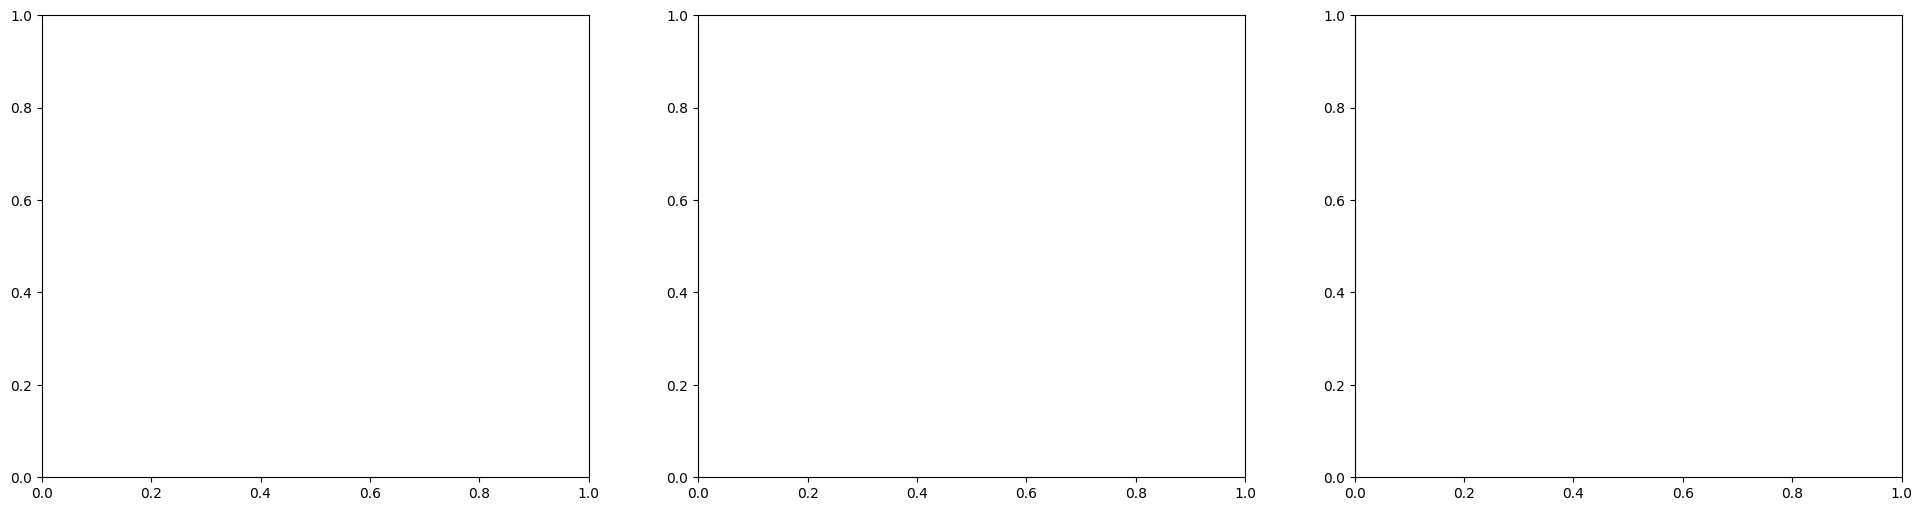

In [7]:
# Determine number of clusters
num_clusters = len(set(cluster_mapping_org.values()))

cols = 3
rows = (num_clusters + cols - 1) // cols  # Round up division

fig, axs = plt.subplots(rows, cols, figsize=(cols * 8, rows * 6))

# Flatten axs if it's a single row or column
if rows == 1 or cols == 1:
    axs = axs.ravel()

for cluster_id in range(1, num_clusters + 1):
    nodes_in_cluster = [node for node, cluster in cluster_mapping_org.items() if cluster == cluster_id]
    subgraph = G.subgraph(nodes_in_cluster)
    pos_sub = nx.kamada_kawai_layout(subgraph)  # Adjust layout method as needed
    
    if (rows > 1 and cols > 1) or (rows == 1 and cols > 1):  # Adjusted condition for multi-row plots
        axs[(cluster_id - 1) // cols, (cluster_id - 1) % cols].set_title(f"Cluster {cluster_id}")
        nx.draw(subgraph, pos=pos_sub, ax=axs[(cluster_id - 1) // cols, (cluster_id - 1) % cols], with_labels=True, node_size=500, cmap=plt.cm.jet, font_size=10, font_weight='bold')
    elif rows == 1 and cols == 1:  # Handle case when there's only one subplot
        axs.set_title(f"Cluster {cluster_id}")
        nx.draw(subgraph, pos=pos_sub, ax=axs, with_labels=True, node_size=500, node_color=get_node_colors(subgraph, cluster_mapping_org), cmap=plt.cm.jet, font_size=10, font_weight='bold')

plt.suptitle("Subgraphs of Clustered Graph", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Ensure suptitle does not overlap with subplots
plt.show()


## Spectral Clustering

Determine the number of clusters using Louvain community detection


In [8]:
from community import community_louvain

def detect_communities_louvain(G):
    partition = community_louvain.best_partition(G)
    num_communities = len(set(partition.values()))
    return partition, num_communities

partition_org, num_communities_org = detect_communities_louvain(G_org)
partition_2, num_communities_2 = detect_communities_louvain(G_2)
partition_1, num_communities_1 = detect_communities_louvain(G_1)

print(f"Number of Communities in Original Graph: {num_communities_org}")
print(f"Number of Communities in degree_2 Graph: {num_communities_2}")
print(f"Number of Communities in degree_1 Graph: {num_communities_1}")

Number of Communities in Original Graph: 10
Number of Communities in degree_2 Graph: 11
Number of Communities in degree_1 Graph: 12


Determine the number of clusters using spectral clustering

In [9]:
import numpy as np

# Function to estimate the number of clusters using spectral clustering
def estimate_clusters_spectral(G, max_clusters=10):
    L = nx.laplacian_matrix(G).toarray()
    eigenvalues, _ = np.linalg.eigh(L)
    eigengap = np.diff(eigenvalues)

    # Identify the largest eigengap
    num_clusters = np.argmax(eigengap[:max_clusters]) + 1
    return num_clusters

# Estimate number of clusters for each graph
num_clusters_org = estimate_clusters_spectral(G_org)
num_clusters_2 = estimate_clusters_spectral(G_2)
num_clusters_1 = estimate_clusters_spectral(G_1)

# Print estimated number of clusters
print(f"Estimated Number of Clusters in Original Graph: {num_clusters_org}")
print(f"Estimated Number of Clusters in degree_2 Graph: {num_clusters_2}")
print(f"Estimated Number of Clusters in degree_1 Graph: {num_clusters_1}")


Estimated Number of Clusters in Original Graph: 5
Estimated Number of Clusters in degree_2 Graph: 5
Estimated Number of Clusters in degree_1 Graph: 8


Cluster and visualise the graph (Spectral clustering)

c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\tadas\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\tadas\AppData\Local\Temp\ipykernel_21252\2068337366.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and

[2 2 4 2 4 0 2 0 3 0 0 0 1 0 0 0 0 0 0 0 1 4 2 1 0 1 0 2 0 0 0 0 4 0 0 4 0
 4 0 0 4 2 2 0 0 2 1 0 2 0 0 2 3 0 4 0 3 3 0 2 1 3 0 4 2 4 0 2 2 4 2 2 0 1
 0 0 0 0 0 0 0 0 0 0 3]


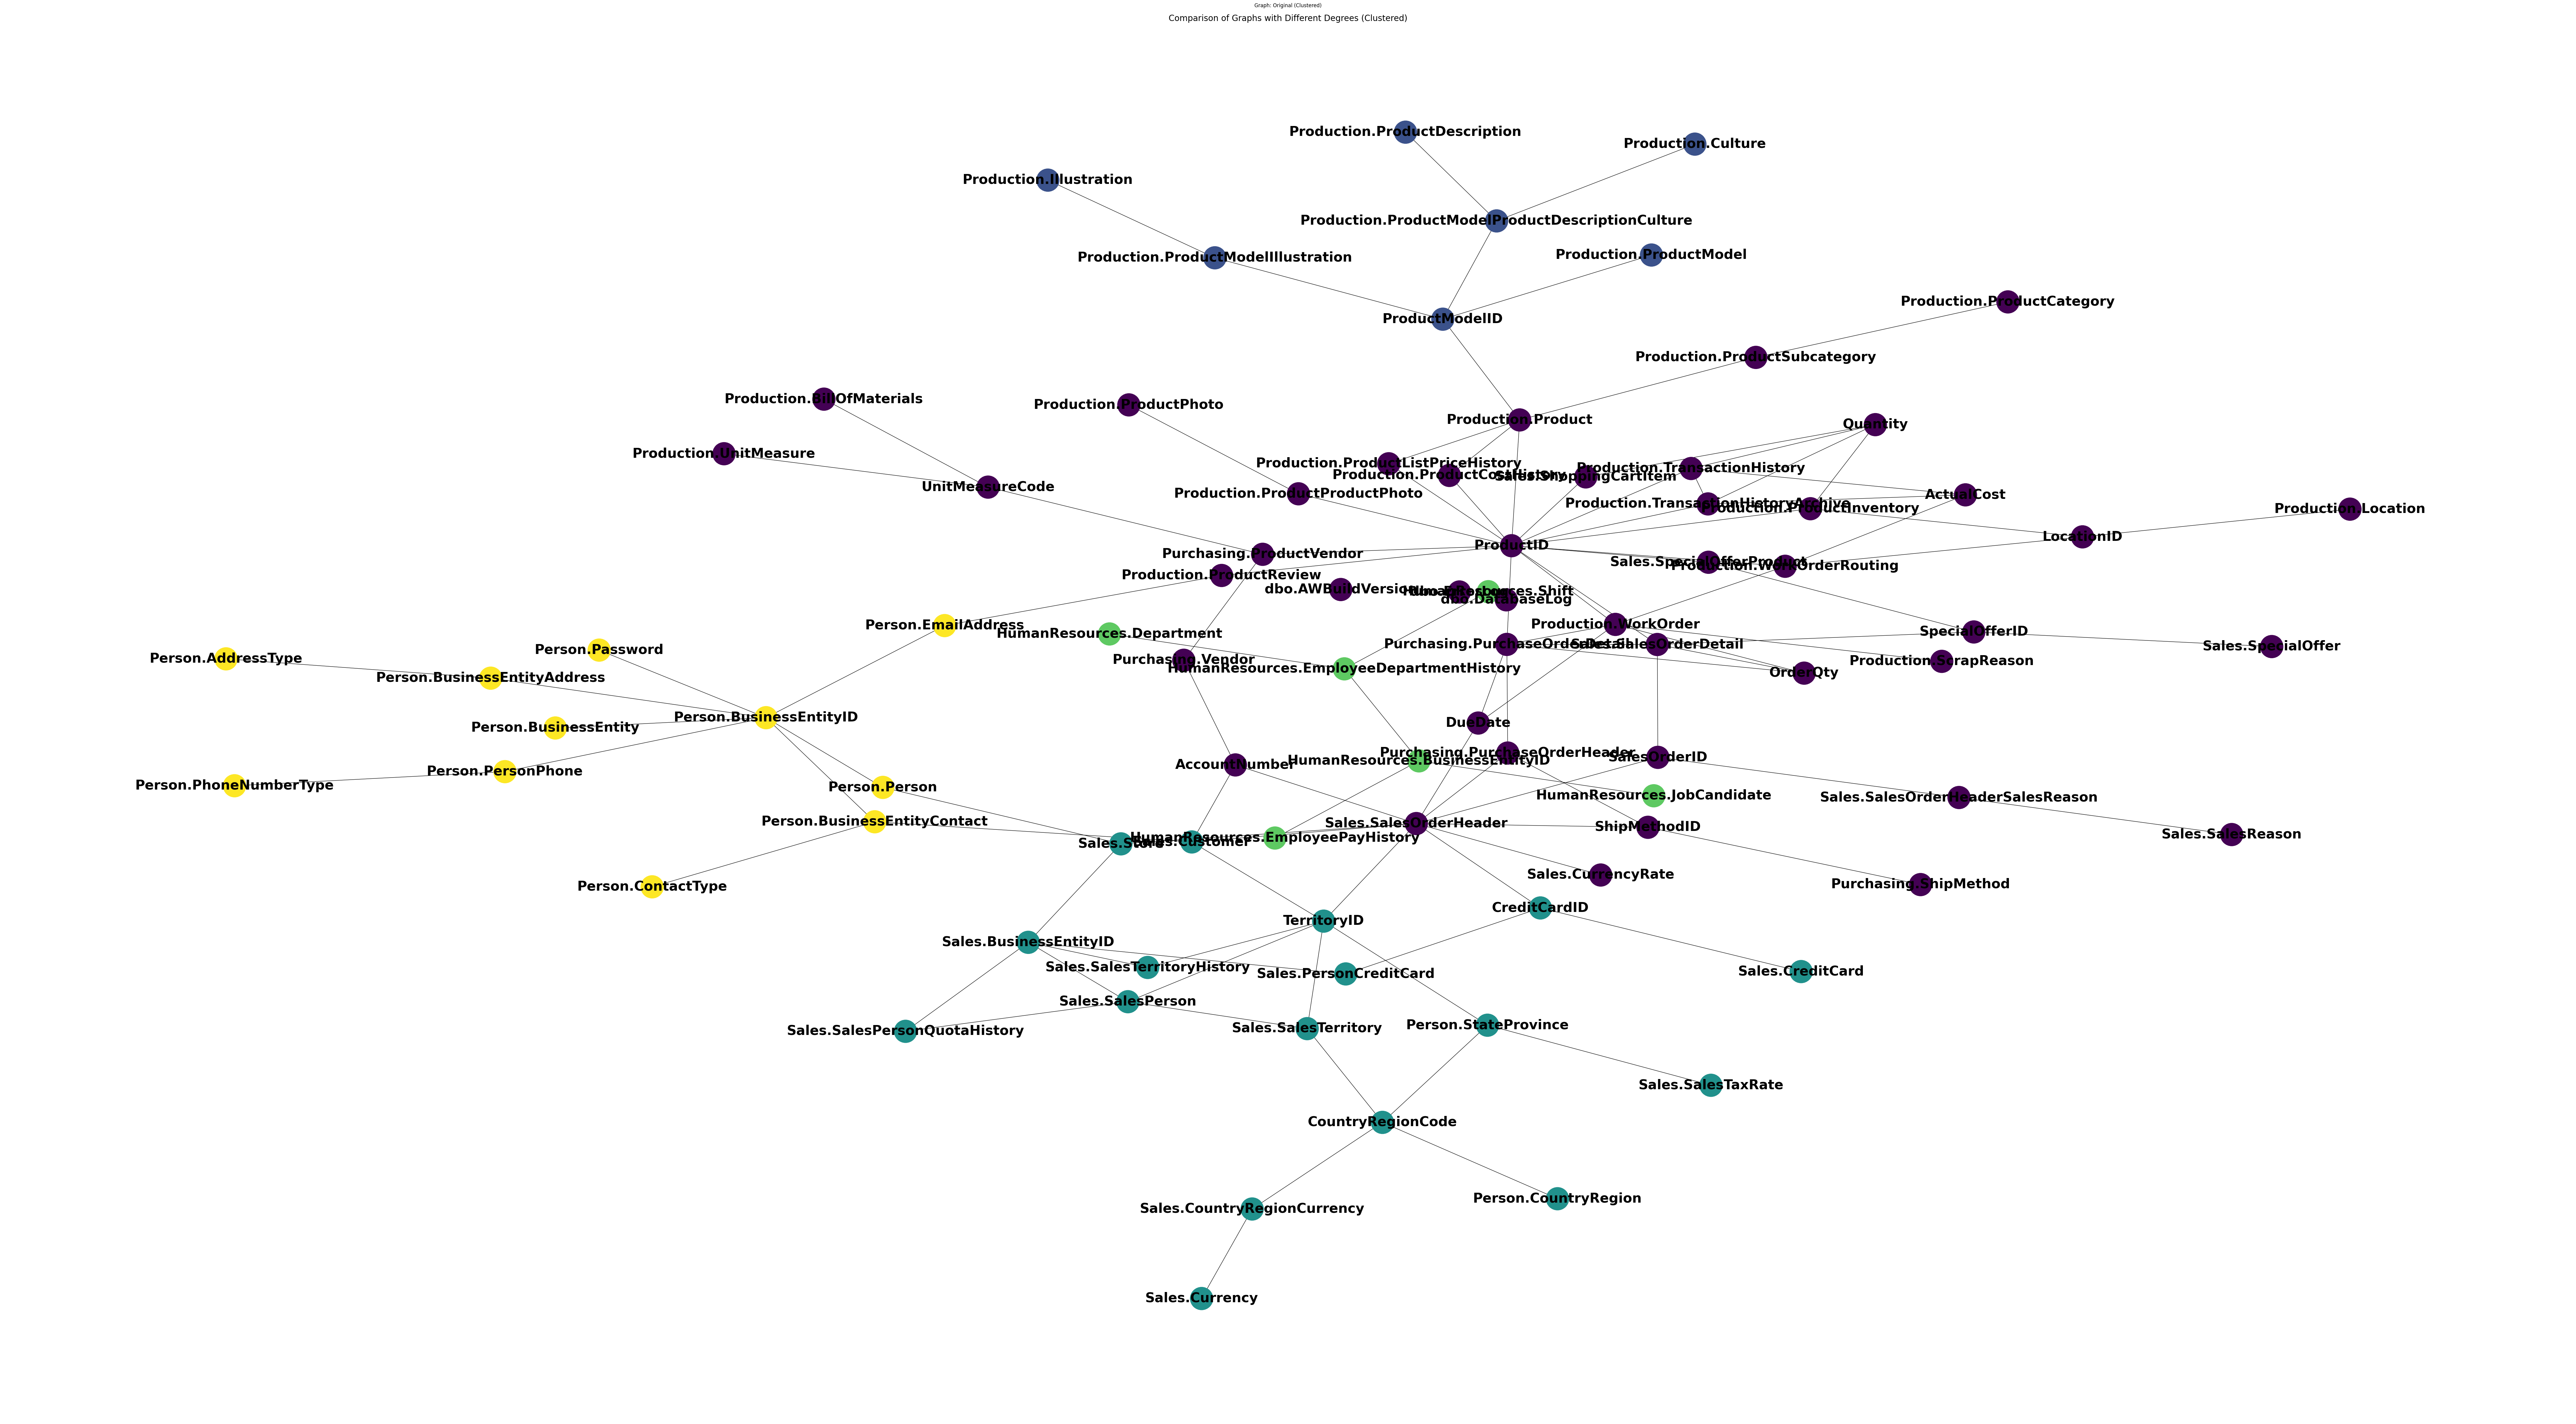

In [10]:
from sklearn.cluster import spectral_clustering

def graph_to_adjacency_matrix(G):
    return nx.to_numpy_array(G)

def get_node_colors(G, cluster_labels):
    num_clusters = len(set(cluster_labels))  # Number of clusters
    cmap = plt.cm.get_cmap('viridis', num_clusters)  # Colormap 
    node_colors = [cmap(label) for label in cluster_labels]
    return node_colors

def spectral_cluster_and_plot(G, ax):
    A = graph_to_adjacency_matrix(G)
    cluster_labels = spectral_clustering(A, n_clusters=5)  ##### Set the number of clusters #####
    node_colors = get_node_colors(G, cluster_labels)
    pos = nx.kamada_kawai_layout(G)  
    nx.draw(G, pos=pos, with_labels=True, node_color=node_colors, cmap=plt.cm.viridis, node_size=3000, font_size=32, font_weight='bold', ax=ax)
    return cluster_labels, pos, node_colors

fig, axs = plt.subplots(1, 1, figsize=(86, 48))

axs.set_title("Graph: Original (Clustered)")
cluster_labels, pos, node_colors = spectral_cluster_and_plot(G, axs) # Set which graph to work on (G_org, G_1, G_2)

print(cluster_labels)
plt.suptitle("Comparison of Graphs with Different Degrees (Clustered)", fontsize=20)
plt.tight_layout()
plt.show()

Visualize the results of spectral clustering as seperate subgraphs

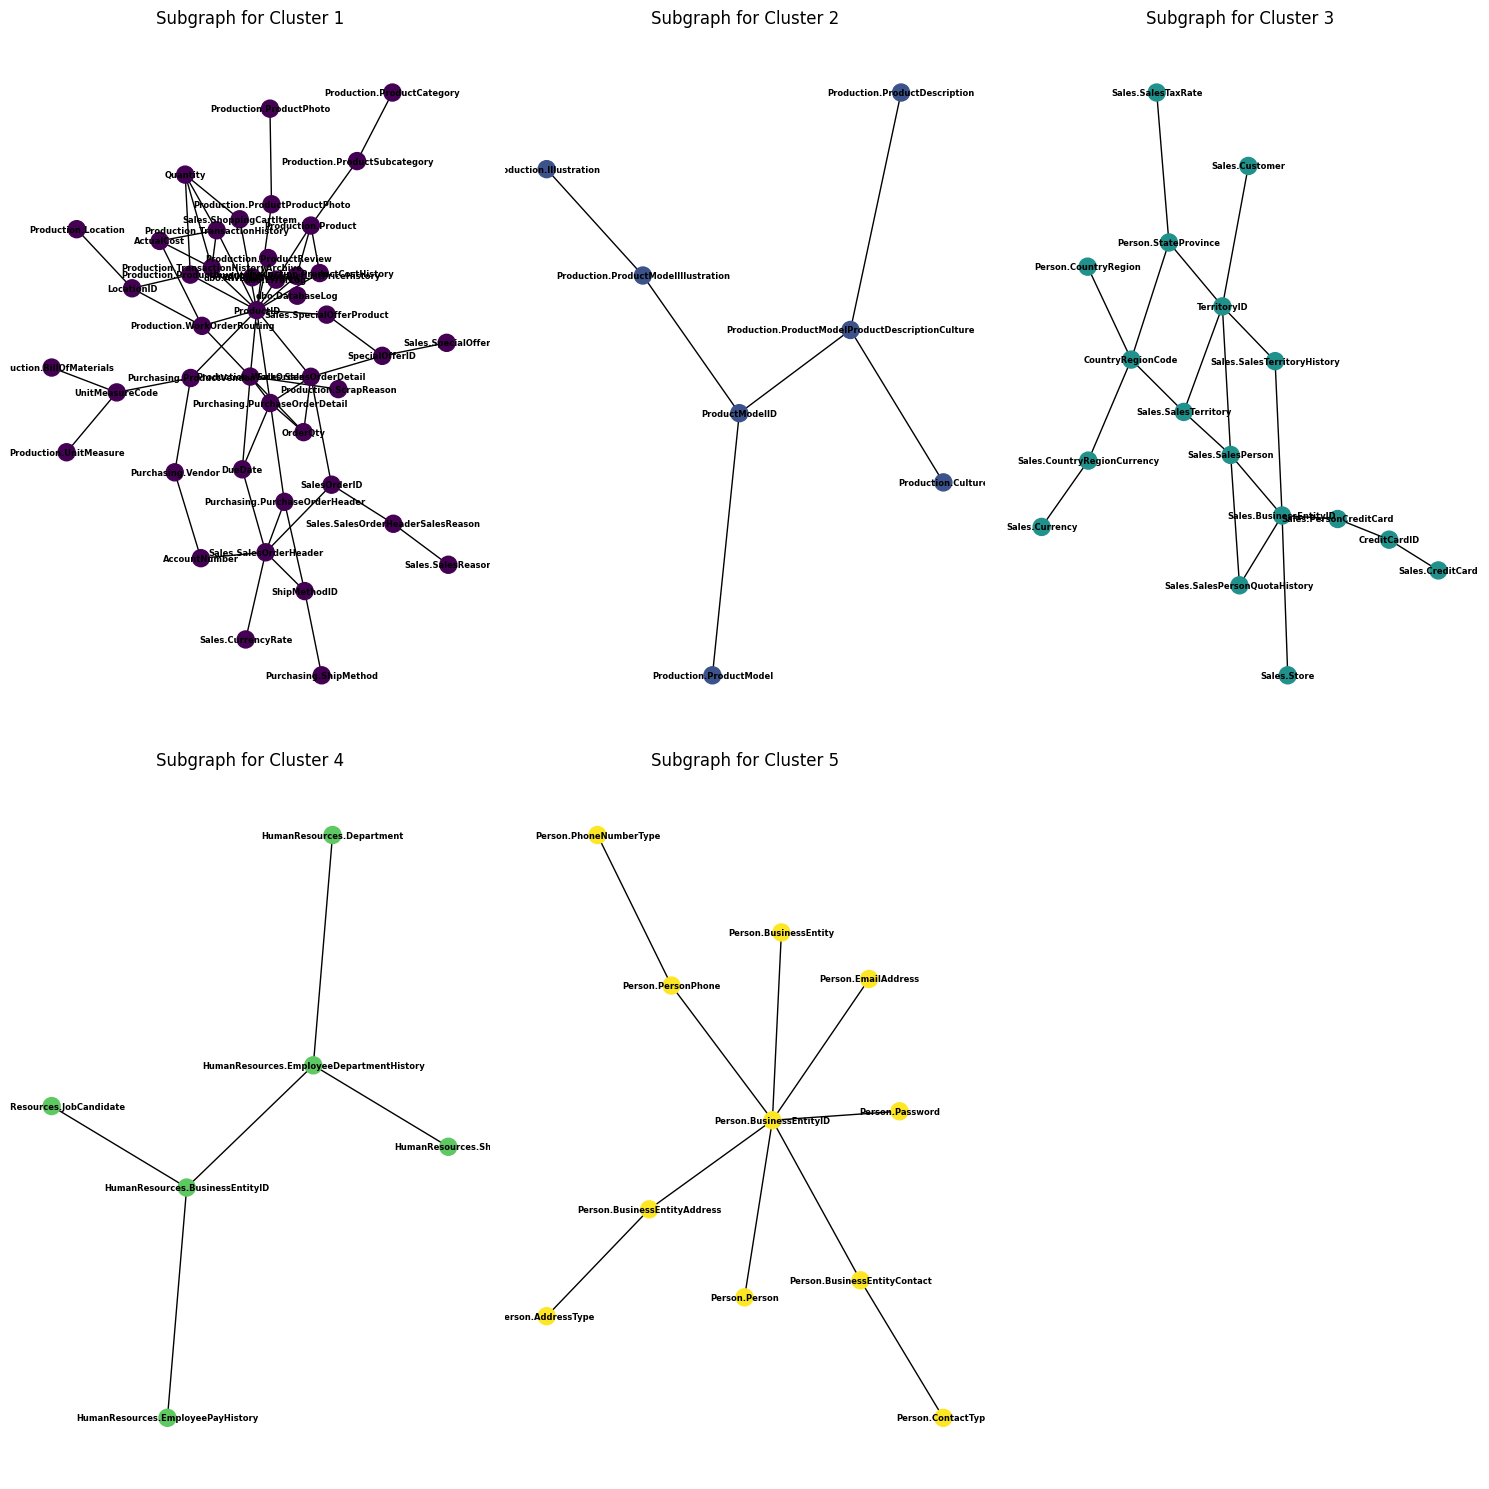

In [11]:
import math
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

subgraph_node_data = pd.DataFrame()

unique_clusters = sorted(set(cluster_labels))  # Get sorted list of unique clusters
num_clusters = len(unique_clusters)

cols = 3  # Number of columns for the subplot grid
rows = math.ceil(num_clusters / cols)  # Number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the array of axes for easy iteration

for i, cluster_id in enumerate(unique_clusters):
    ax = axes[i]

    # Extract nodes belonging to the chosen cluster
    subgraph_node_indexes = [node for node, label in enumerate(cluster_labels) if label == cluster_id]
    label_to_index = {label: index for index, label in enumerate(G.nodes())}
    subgraph_nodes = [k for k, v in label_to_index.items() if v in subgraph_node_indexes]

    # Populate the DataFrame with subgraph node data
    new_data = pd.DataFrame({'cluster_label': cluster_id, 'node_label': subgraph_nodes})
    subgraph_node_data = pd.concat([subgraph_node_data, new_data], ignore_index=True)

    # Construct subgraph manually
    subgraph = G.subgraph(subgraph_nodes)

    # Plot the subgraph
    pos_subgraph = nx.kamada_kawai_layout(subgraph)
    nx.draw(subgraph, pos=pos_subgraph, with_labels=True, 
            node_color=[node_colors[label_to_index[node]] for node in subgraph],
            cmap=plt.cm.viridis, node_size=150, font_size=6, font_weight='bold', ax=ax)
    ax.set_title(f"Subgraph for Cluster {cluster_id+1}")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


## Compare clusters to schemas
Evaluate results against schema definitions

In [12]:
def remove_schema_names(entry):
    return entry.split('.')[1] if '.' in entry else entry

subgraph_node_data.loc[:, 'node_label'] = subgraph_node_data['node_label'].apply(remove_schema_names) # spectral
subgraph_node_data = subgraph_node_data[~subgraph_node_data['node_label'].str.contains('ID')] #spectral

'''clique_cluster_df.loc[:, 'node_label'] = clique_cluster_df['node_label'].apply(remove_schema_names) # Clique
clique_cluster_df = clique_cluster_df[~clique_cluster_df['node_label'].str.contains('ID')] #Clique
subgraph_node_data = clique_cluster_df
'''

table_names_df = pd.read_csv(r"C:\Python\Python\AAA_UNI\MBD\Project\gitlab\graph_analysis\tables_and_schemas")

#print(table_names_df.head(10).sort_values(by='table_schema'))
#print(subgraph_node_data.head(10).sort_values(by='node_label'))


In [13]:
def calculate_similarity(schema_df, cluster_df):
    schema_set = set(schema_df['table_name'])
    matching = sum(1 for label in cluster_df['node_label'] if label in schema_set)
    total_schema = len(schema_df)
    total_cluster = len(cluster_df)
    return matching, total_schema, total_cluster

# Initialize variables to store results
best_matches = {}
best_similarity = {}
match_ratio = {}

# Iterate over each unique cluster in subgraph_node_data
unique_clusters = subgraph_node_data['cluster_label'].unique()
for cluster in unique_clusters:
    cluster_df = subgraph_node_data[subgraph_node_data['cluster_label'] == cluster]
    best_similarity[cluster] = 0.0
    best_matches[cluster] = None
    
    # Iterate over each schema in table_names_df
    unique_schemas = table_names_df['table_schema'].unique()
    for schema in unique_schemas:
        schema_df = table_names_df[table_names_df['table_schema'] == schema]
        # Calculate similarity between current cluster and current schema
        matching, total_schema, total_cluster = calculate_similarity(schema_df, cluster_df)
        
        # Calculate similarity percentage
        similarity_percentage = (matching / total_cluster) * 100
        
        # Update best match if current similarity is higher than previously recorded
        if similarity_percentage > best_similarity[cluster]:
            best_similarity[cluster] = similarity_percentage
            best_matches[cluster] = schema
        
        # Store match ratio
        match_ratio[(cluster, schema)] = f"{total_cluster}/{matching}"
        
overall_average_similarity = 0
# Output the best matches and their similarity percentages
for cluster, schema in best_matches.items():
    print(f"Best match for cluster {cluster+1} is schema '{schema}' with similarity {best_similarity[cluster]:.2f}% ({match_ratio[(cluster, schema)]})")
    overall_average_similarity += best_similarity[cluster]
print(f'Overall Average similiarity: {(overall_average_similarity/len(best_matches.items())):.2f}%')


Best match for cluster 1 is schema 'Production' with similarity 43.59% (39/17)
Best match for cluster 2 is schema 'Production' with similarity 100.00% (6/6)
Best match for cluster 3 is schema 'Sales' with similarity 78.57% (14/11)
Best match for cluster 4 is schema 'HumanResources' with similarity 100.00% (5/5)
Best match for cluster 5 is schema 'Person' with similarity 100.00% (10/10)
Overall Average similiarity: 84.43%
